# Class Workbook

## In class activity

In [48]:
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import subplots
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
import statsmodels.formula.api as sm
#import ISLP as islp

In [163]:
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

### Ames Housing data

Please take a look at the Ames Hoursing data.

In [43]:
ames_raw=pd.read_csv("ames_raw.csv")

### Questions

Use data of `ames_raw` up to 2008 predict the housing price for the later years.

In [88]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

Use the same loss function calculator.

In [86]:
def calc_loss(prediction,actual):
  difpred = actual-prediction
  RMSE =pow(difpred.pow(2).mean(),1/2)
  operation_loss=abs(sum(difpred[difpred<0]))+sum(0.1*actual[difpred>0])
  return RMSE,operation_loss

Here are few rules:

- You are not allowed to use the test data.
- Try 3 of the regularization methods discussed in Ch6.
- You should use a resampling method that is most appropriate for choosing the hyper parameters.

Your code:

In [104]:
# remove variables with lots of missing variables
columns_to_exclude = ['Lot Frontage', 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
ames_raw_2008_sub = ames_raw_2008.drop(columns=columns_to_exclude)

# remove missing values from the sub data set
ames_raw_2008_sub.dropna(inplace=True)

# transform object class to category to create dummy variable using MS class
object_columns = ames_raw_2008_sub.select_dtypes(include='object').columns
ames_raw_2008_sub[object_columns] = ames_raw_2008_sub[object_columns].astype('category')

In [102]:
design = MS(ames_raw_2008_sub.columns.drop('SalePrice')).fit(ames_raw_2008_sub)
D = design.fit_transform(ames_raw_2008_sub)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
Y = np.array(ames_raw_2008_sub['SalePrice'])

In [170]:
# Same process for test data set.
# remove variables with lots of missing variables
ames_raw_2009_sub = ames_raw_2009.drop(columns=columns_to_exclude)

# remove missing values from the sub data set
ames_raw_2009_sub.dropna(inplace=True)

# transform object class to category to create dummy variable using MS class
ames_raw_2009_sub[object_columns] = ames_raw_2009_sub[object_columns].astype('category')

design = MS(ames_raw_2009_sub.columns.drop('SalePrice')).fit(ames_raw_2009_sub)
D_t = design.fit_transform(ames_raw_2009_sub)
D_t = D_t.drop('intercept', axis=1)
X_t = np.asarray(D_t)
Y_t = np.array(ames_raw_2009_sub['SalePrice'])

In [103]:
# Ridge 
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0., # with Ridge regularization
                                 alphas=lambdas)[1]
soln_array.shape

/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25583647044459.684, tolerance: 5124035125.0136
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

(228, 100)

In [105]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

Order         PID  MS SubClass  MS Zoning[FV]  \
negative log(lambda)                                                        
-7.103652              -10.209539  -15.169356    -4.380423       4.052811   
-6.871067              -12.840061  -19.075189    -5.527511       5.080714   
-6.638483              -16.134536  -23.965345    -6.974942       6.358542   
-6.405899              -20.252638  -30.075652    -8.801288       7.940852   
-6.173314              -25.387974  -37.691523   -11.105605       9.890527   
...                           ...         ...          ...            ...   
 14.991862           -8127.539170  626.256023 -6649.753477    4421.232919   
 15.224446           -8127.599336  626.282381 -6649.753671    4421.265876   
 15.457031           -8127.647018  626.303270 -6649.753825    4421.291994   
 15.689615           -8127.684806  626.319825 -6649.753947    4421.312692   
 15.922199           -8127.714753  626.332944 -6649.754043    4421.329095   

                      MS Zoning[RH]  MS Zoning[RL]  MS Zoning[RM]  \
negative log(lambda)                                                
-7.103652                 -3.318717      15.701801     -18.612376   
-6.871067                 -4.177850      19.746968     -23.396677   
-6.638483                 -5.256200      24.812833     -29.381930   
-6.405899                 -6.607865      31.144625     -36.853035   
-6.173314                 -8.299258      39.039500     -46.153059   
...                             ...            ...            ...   
 14.991862               702.487838    6560.254975    6554.902323   
 15.224446               702.499114    6560.313891    6554.948368   
 15.457031               702.508050    6560.360581    6554.984858   
 15.689615               702.515132    6560.397582    6555.013777   
 15.922199               702.520744    6560.426905    6555.036694   

                         Lot Area  Street[Pave]  Lot Shape[IR2]  ...  \
negative log(lambda)                                             ...   
-7.103652               20.026863      0.595840        7.059705  ...   
-6.871067               25.216111      0.750957        8.882172  ...   
-6.638483               31.732201      0.946183       11.166692  ...   
-6.405899               39.904152      1.191750       14.025586  ...   
-6.173314               50.136736      1.500432       17.595765  ...   
...                           ...           ...             ...  ...   
 14.991862            5516.337590   1578.716543      719.220548  ...   
 15.224446            5516.333430   1578.711445      719.219343  ...   
 15.457031            5516.330133   1578.707404      719.218389  ...   
 15.689615            5516.327520   1578.704202      719.217632  ...   
 15.922199            5516.325449   1578.701664      719.217032  ...   

                      Sale Type[ConLw]  Sale Type[New]  Sale Type[Oth]  \
negative log(lambda)                                                     
-7.103652                    -3.309592       25.874293       -1.684860   
-6.871067                    -4.160438       32.528063       -2.118575   
-6.638483                    -5.224937       40.853739       -2.661516   
-6.405899                    -6.553821       51.248963       -3.339791   
-6.173314                    -8.208216       64.193228       -4.184952   
...                                ...             ...             ...   
 14.991862                  -79.673219     6918.214571      511.021652   
 15.224446                  -79.672925     6918.262247      511.020127   
 15.457031                  -79.672692     6918.300030      511.018919   
 15.689615                  -79.672508     6918.329973      511.017961   
 15.922199                  -79.672362     6918.353703      511.017202   

                      Sale Type[VWD]  Sale Type[WD ]  Sale Condition[AdjLand]  \
negative log(lambda)                                                            
-7.103652                  -1.197897      -17.825529              

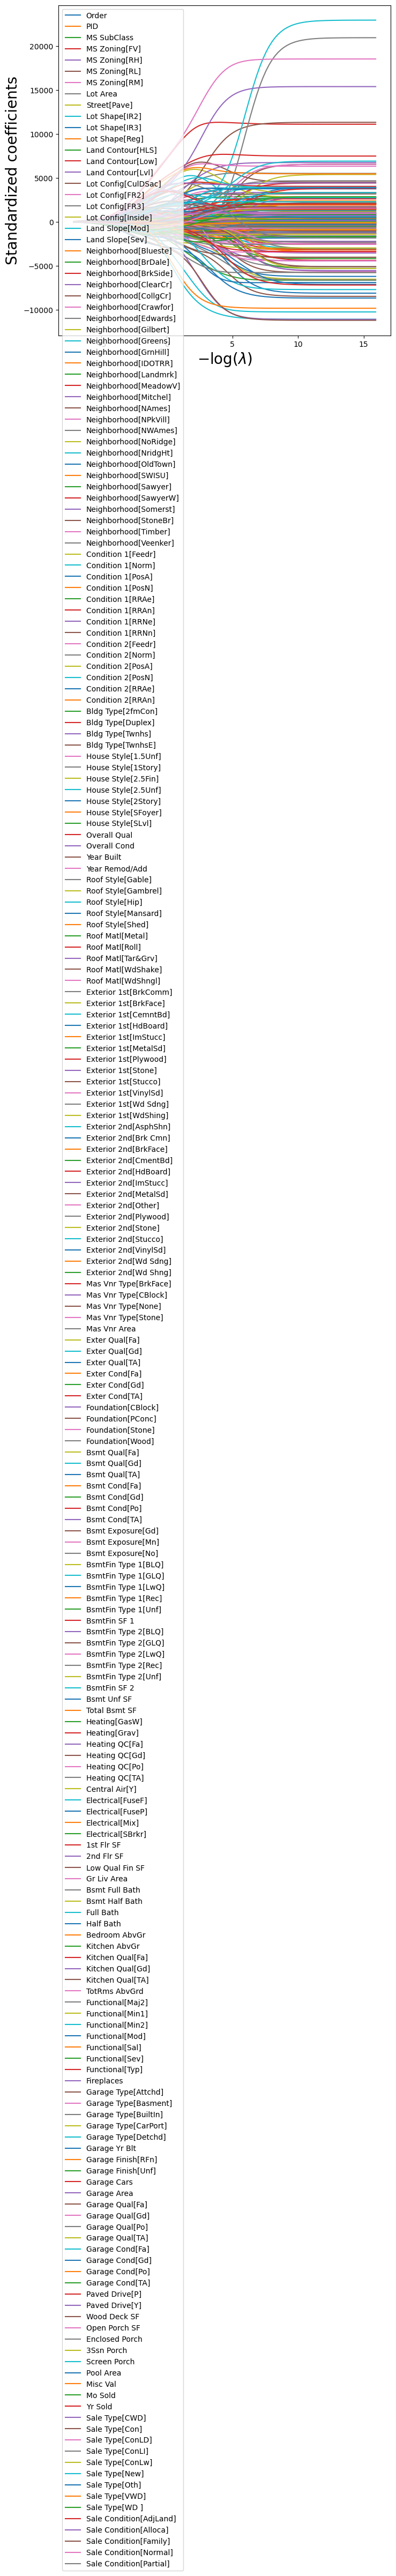

In [106]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [125]:
# Kfold cross validation
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

param_grid = {'ridge__alpha': lambdas}

ridge = skl.ElasticNet(l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])


grid = skm.GridSearchCV(pipe, 
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
print(grid.best_params_['ridge__alpha'])
grid.best_estimator_

/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+12, tolerance: 6.769e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+12, tolerance: 6.260e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge

0.28100434785507333


/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.215e+11, tolerance: 8.198e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.28100434785507333, l1_ratio=0))])

In [135]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3384089563111.2427, tolerance: 676933773.8600065
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([65062.67653502, 60677.66989374, 56588.19802397, 52774.34287125,
       49217.52879129, 45900.43207608, 42806.89657754, 39921.85501789,
       37231.25560347, 34721.99358446, 32381.84742733, 30199.41928899,
       28164.07950284, 26265.91480623, 24495.68005724, 22844.75320557,
       21305.09329823, 19869.20131559,...
         323.81847427,   301.99419289,   281.64079503,   262.65914806,
         244.95680057,   228.44753206,   213.05093298,   198.69201316,
         185.30083647,   172.81218027,   161.1652177 ,   150.30322143,
         140.17328735,   130.72607693,   121.91557687,   113.69887503,
         106.03595139,    98.88948315,    92.22466296,    86.00902934,
          80.21230863,    74.80626749,    69.76457542,    65.06267654]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

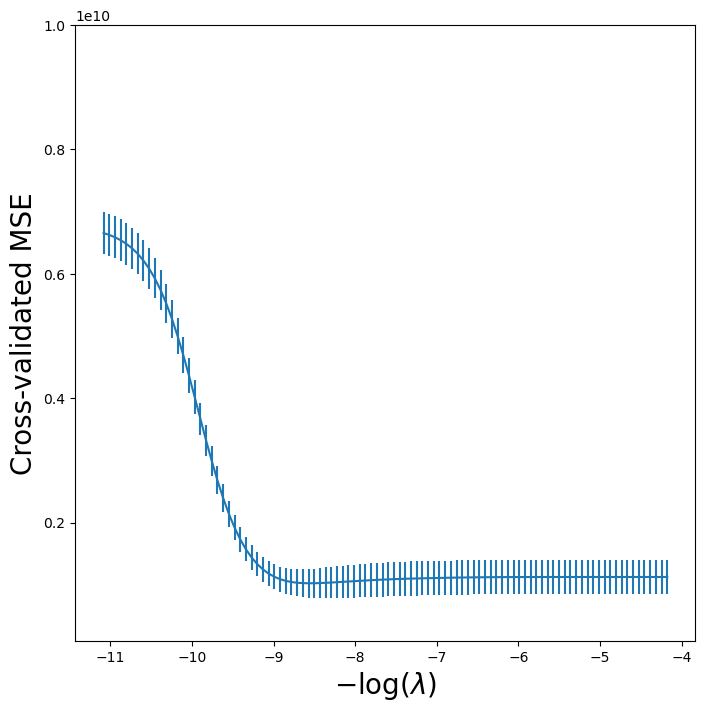

In [138]:
tuned_ridge = pipeCV.named_steps['ridge']
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([100000000,10000000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [139]:
np.min(tuned_ridge.mse_path_.mean(1))

5127744068.62277

In [126]:
# Lasso
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1, # Lasso
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


492.17528791288873

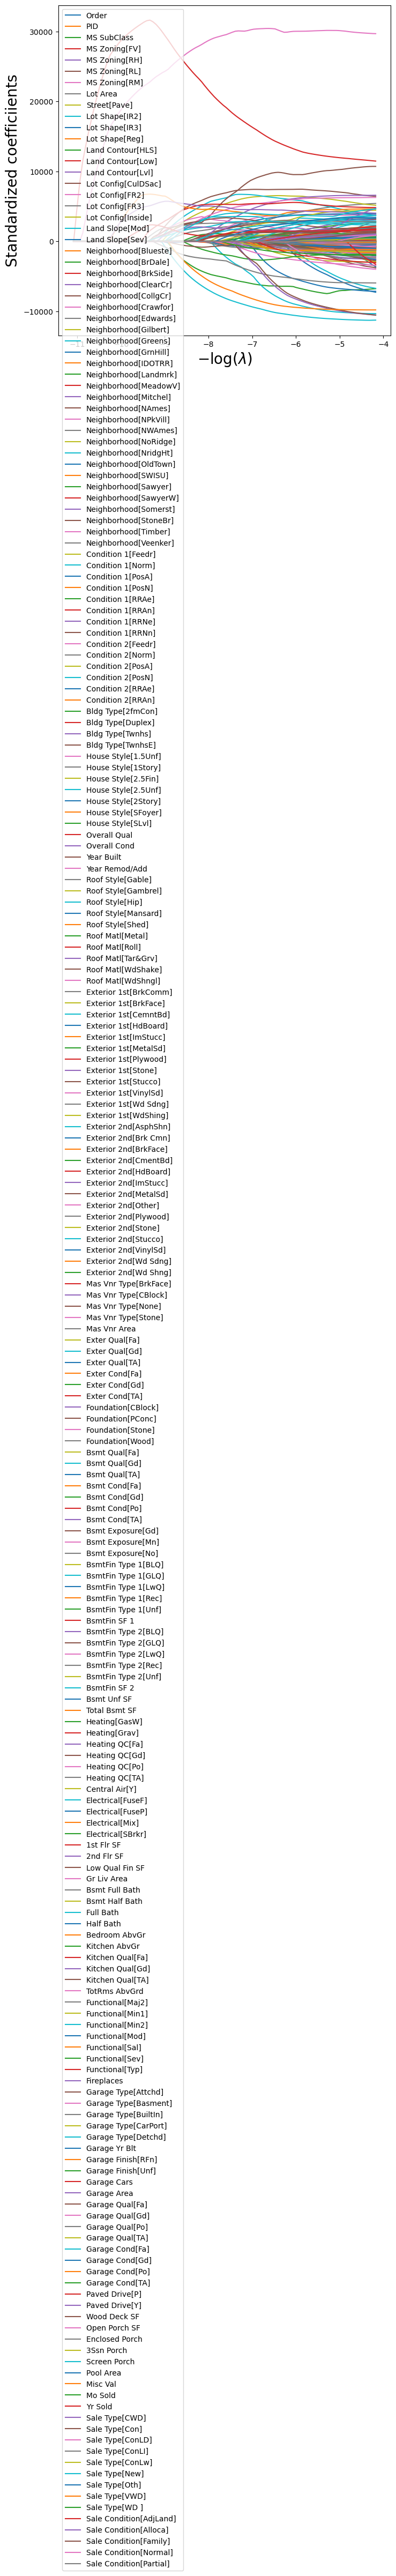

In [128]:
lambdas, soln_array = skl.Lasso.path(Xs, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


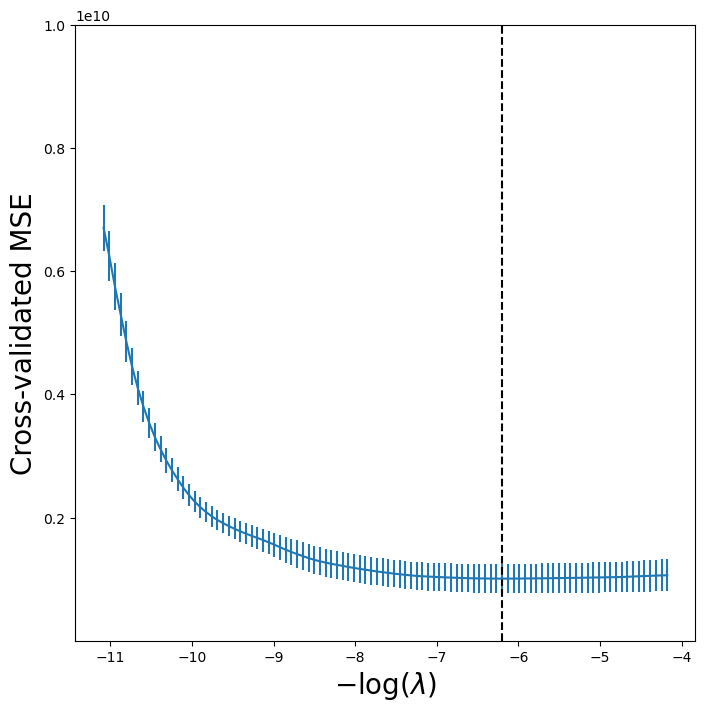

In [134]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([1000000,10000000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [140]:
np.min(tuned_lasso.mse_path_.mean(1))

1008954555.4251165

In [145]:
# Principle Component Regression
pca = PCA(n_components=2)
linreg = skl.LinearRegression()

pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

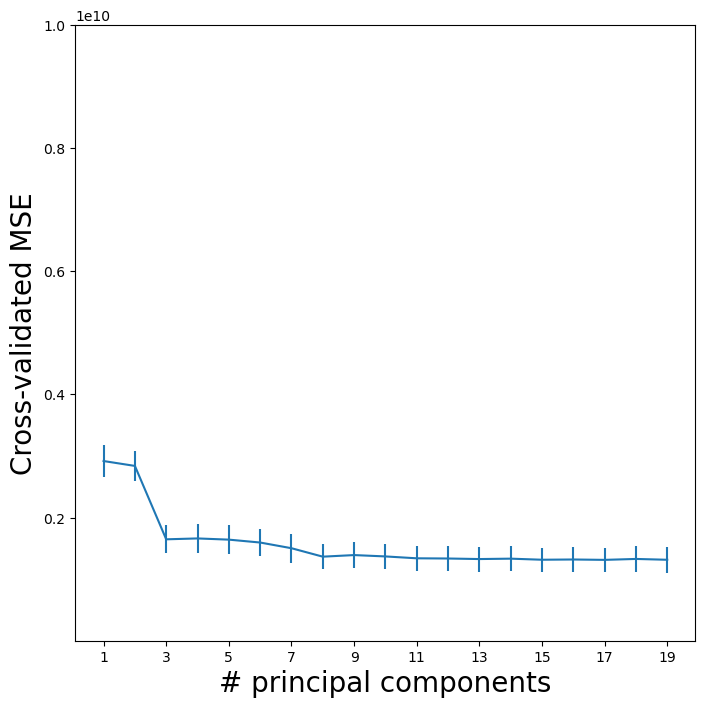

In [154]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([1000000,10000000000]);

In [155]:
# best numner of components
n_comp[np.argmin(-grid.cv_results_['mean_test_score'])]

17

In [156]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

6770287958.859343

Your answer:

~~~
Please write your answer in full sentences.

From the calculations and graphs, the best paratemers are as follow,

Ridge: lambda = 0.28, closs-valideted MSE = 5,127,744,069
Lasso: lambda = 492.2 closs-valideted MSE = 1,008,954,555
PCR: Number of components = 17, closs-valideted MSE = 6,770,287,959

~~~

- For each of the models you've run, can you interpret which variable impacts the outcome the most?
Are the results consistent across different methods?

Your code:

In [159]:
# To identify the variables that have the most impact, we can look at the standardized coefficients of the variables.
# X was standardized before fitting the Ridg/Lasso/PCR regression model. 

# Ridge
# Extract coefficients from the tuned Ridge model
coefficients_r = tuned_ridge.coef_

# Create a DataFrame to store the coefficients along with their corresponding variable names
coefficients_df_r = pd.DataFrame({'Variable': D.columns, 'Coefficient': coefficients_r})

# Sort the DataFrame by the absolute values of coefficients to identify the most impactful variables
coefficients_df_r = coefficients_df_r.reindex(coefficients_df_r['Coefficient'].abs().sort_values(ascending=False).index)

# Print the top variables with the highest absolute coefficients
print(coefficients_df_r.head(10))


             Variable  Coefficient
73       Overall Qual   830.925791
166       Gr Liv Area   798.787288
193       Garage Cars   663.503339
194       Garage Area   651.561301
163        1st Flr SF   649.619616
151     Total Bsmt SF   645.628115
120    Exter Qual[TA]  -609.415075
169         Full Bath   590.021239
176     TotRms AbvGrd   569.234461
175  Kitchen Qual[TA]  -536.925349


In [160]:
# Lasso
# Extract coefficients from the tuned Ridge model
coefficients_l = tuned_lasso.coef_

# Create a DataFrame to store the coefficients along with their corresponding variable names
coefficients_df_l = pd.DataFrame({'Variable': D.columns, 'Coefficient': coefficients_l})

# Sort the DataFrame by the absolute values of coefficients to identify the most impactful variables
coefficients_df_l = coefficients_df_l.reindex(coefficients_df_l['Coefficient'].abs().sort_values(ascending=False).index)

# Print the top variables with the highest absolute coefficients
print(coefficients_df_l.head(10))

                  Variable   Coefficient
166            Gr Liv Area  29884.307563
73            Overall Qual  13611.396687
59       Condition 2[PosN] -10419.916415
75              Year Built   9685.654002
211               Misc Val  -9300.469039
129          Bsmt Qual[Gd]  -8598.734885
174       Kitchen Qual[Gd]  -7720.183376
45   Neighborhood[StoneBr]   7440.623705
175       Kitchen Qual[TA]  -7412.292256
38   Neighborhood[NoRidge]   6506.615357


In [162]:
# how we can calclulate the cefficients of original variable for the PCR outcome?


Your answer:

~~~
Please write your answer in full sentences.

"Gr Liv Area" and "Overall Qual" were identified as the most or second most important variables by Ridge or Lasso regression. However, the rankings of other variables varied significantly among different methods. Therefore, it can be concluded that the orders of importance differed across the different methods used for analysis.
~~~

- Try these methods with bootstrap, are the results consistent?

Your code:

In [164]:
# Ridge with bootstrap

# Define the range of alpha values
alphas = np.logspace(-2, 8, 100)  # Example range of alpha values

# Define the number of bootstrap iterations
n_bootstrap = 100

# Create empty list to store mean squared errors
mean_squared_errors = []

# Perform bootstrap iterations for each alpha value
for alpha in alphas:
    # Create empty list to store MSE for each bootstrap iteration
    mse_alpha = []
    
    # Perform bootstrap iterations
    for i in range(n_bootstrap):
        # Resample the dataset with replacement
        X_boot, Y_boot = resample(X, Y)
        
        # Standardize the bootstrapped dataset
        X_boot_scaled = StandardScaler().fit_transform(X_boot)
        
        # Fit ridge regression model
        ridge = skl.ElasticNet(alpha=alpha, l1_ratio=0)
        ridge.fit(X_boot_scaled, Y_boot)
        
        # Calculate MSE
        mse = np.mean((ridge.predict(X_boot_scaled) - Y_boot) ** 2)
        mse_alpha.append(mse)
    
    # Calculate mean MSE for the current alpha
    mean_mse_alpha = np.mean(mse_alpha)
    mean_squared_errors.append(mean_mse_alpha)

# Find the optimal alpha with the lowest mean squared error
optimal_alpha_index = np.argmin(mean_squared_errors)
optimal_alpha = alphas[optimal_alpha_index]

print("Optimal alpha:", optimal_alpha)

/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.630e+11, tolerance: 8.285e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+11, tolerance: 7.471e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge

Optimal alpha: 0.01


/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e+12, tolerance: 9.869e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


Your answer:

~~~
Please write your answer in full sentences.

Ridge with bootstrap: Optimal lamba = 0.01. This is a bit difference from one from ridge with Cross Validation (otimal lambda = 0.28)

# It took 84minutes to calculate, so I skip Lasso with bootstrap and PCR with bootstrap. 
~~~

- Based on all the models you've run, which result predicts the best?  Which one is most easy to understand?  Which method gives the most stable results?

Your code:

In [175]:
## Debug is needed for this chunk

# Train Ridge regression model with the best alpha value
ridge_model = skl.ElasticNet(alpha=0.28, l1_ratio=0)
ridge_model.fit(X, Y)

# Make predictions using the trained model
ridge_predictions = ridge_model.predict(X_t)

# Calculate loss using calc_loss function
ridge_RMSE, ridge_operation_loss = calc_loss(ridge_predictions, Y_t)

# Print RMSE and operation loss
print("Ridge RMSE:", ridge_RMSE)
print("Ridge operation loss:", ridge_operation_loss)

#

/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.383e+11, tolerance: 8.198e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


ValueError: X has 224 features, but ElasticNet is expecting 228 features as input.

In [171]:
Y_t

array([215000, 105000, 172000, ..., 137500, 172000, 103000])

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Problem Set

### Best Subset

In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.

(a) Use the `normal()` function to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.

Your code:

In [9]:
#
#

(b) Generate a response vector $Y$ of length $n = 100$ according to the model $$\mathbf{y} = \boldsymbol{\beta}_0 + \beta_1X + \beta2X^2 + \beta_3X^3 + \epsilon$$, where $\beta_{0}$ , $\beta_{1}$, $\beta_{2}$, and $\beta_{3}$ are constants of your choice.

Your code:

In [10]:
#
#

(c) Use the `regsubsets()` function to perform best subset selection in order to choose the best model containing the predictors $X$, $X^{2},\dots,X^{10}$. What is the best model obtained according to $C_p$ , BIC, and adjusted $R^2$ ? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the `data.frame()` function to create a single data set containing both $X$ and $Y$.

Your code:

In [11]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?

Your code:

In [12]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(e) Now fit a lasso model to the simulated data, again using $X$, $X^{2},\dots, X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

Your code:

In [13]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(f) Now generate a response vector Y according to the model $$Y = \beta_{0} + \beta_{7}X^{7} + \epsilon,$$and perform best subset selection and the lasso. Discuss the results obtained.

Your code:

In [14]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### College

In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [15]:
from ISLP import load_data
College = load_data("College")

(a) Split the data set into a training set and a test set.

Your code:

In [16]:
#
#

(b) Fit a linear model using least squares on the training set, and report the test error obtained.

Your code:

In [17]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.


Your code:

In [18]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Fit a lasso model on the training set, with $\lambda$ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

Your code:

In [19]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.


Your code:

In [20]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.


Your code:

In [21]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?


Your code:

In [22]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Features

We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

(a) Generate a data set with (p = 20) features, (n = 1,000) observations, and an associated quantitative response vector generated according to the model $$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$$, where ($\boldsymbol{\beta}$) has some elements that are exactly equal to zero.

Your code:

In [23]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Split your data set into a training set containing (100) observations and a test set containing (900) observations.


Your code:

In [24]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

Your code:

In [25]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Plot the test set MSE associated with the best model of each size.

Your code:

In [26]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~
(e) For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

Your code:

In [27]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.


Your code:

In [28]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(g) Create a plot displaying $\sqrt{\sum_{j=1}^{p}(\beta_{j}-\hat{\beta}_{j}^{r})^{2}}$ for a range of values of ($r$), where $\hat{\beta}_{j}^{r}$ is the $j$th coefficient estimate for the best model containing ($r$) coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?


Your code:

In [29]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Boston

We will now try to predict per capita crime rate in the Boston data set.

In [30]:
Boston = load_data("Boston")

(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.


Your code:

In [31]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, crossvalidation, or some other reasonable alternative, as opposed to using training error.


Your code:

In [32]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Does your chosen model involve all of the features in the data set? Why or why not?


Your code:

In [33]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~



~~~

## Additional Material

### [Advanced] Regularized Regression using Predictive Modeling Platforms in R

#### scikit-learn

Sklearn is probably the goto for most of what you will do on your computer.
Many ways of doing the parameter tuning is described in the lab for your ISLP textbook.

In [34]:
from sklearn.model_selection import train_test_split
# split the data
X_train0, X_test, y_train0, y_test = train_test_split(ames_raw.loc[:,ames_raw.columns != "SalePrice"], ames_raw.loc[:,"SalePrice"], test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split( X_train0, y_train0, test_size=0.25, random_state=11)

train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.
https://www.machinelearningplus.com/pyspark/pyspark-ridge-regression/

In [35]:
import pyspark
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import tempfile
from ISLP import load_data

In [36]:
spark = SparkSession.builder.appName("Ridge_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/09 18:22:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [37]:
Boston = load_data("Boston")
dataset = spark.createDataFrame(Boston)
from pyspark.ml.feature import VectorAssembler
# Define the feature and label columns & Assemble the feature vector
assembler = VectorAssembler(
    inputCols=["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio","lstat"],
    outputCol="features")

dataset = assembler.transform(dataset)
final_data = dataset.select("features", "medv")

# Split the data into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

ridge_regression = LinearRegression(featuresCol="features", labelCol="medv", elasticNetParam=0)
# Define the hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(ridge_regression.regParam, [0.001, 0.01, 0.1, 1.0]) \
    .build()

# Create the cross-validator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol= "medv", metricName="rmse")
cross_validator = CrossValidator(estimator=ridge_regression,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train_data)
ridge_model = cv_model.bestModel

coefficients = ridge_model.coefficients
intercept = ridge_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))
# Make predictions on the test data
predictions = ridge_model.transform(test_data)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2").evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R2):", r2)

24/02/09 18:22:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/02/09 18:22:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=46950Kb max_used=46957Kb free=84121Kb
 bounds [0x00000001069e0000, 0x0000000109810000, 0x000000010e9e0000]
 total_blobs=17058 nmethods=15334 adapters=1634
 compilation: disabled (not enough contiguous free space left)
Coefficients:  [-0.12277300992229778,0.038642520698533425,-0.0054209512954934095,4.534521972344716,-19.194125050494744,3.4823479953536736,-0.00557256738045013,-1.462977078790024,0.253135274801355,-0.009164981038232777,-0.9654422744973572,-0.5219884749517687]
Intercept: 42.719
Root Mean Squared Error (RMSE): 5.204800236345615
Coefficient of Determination (R2): 0.6894712362945186


##### Save and load the model

In [38]:
# Save the model
ridge_model.save("ridge_model")

# Load the model
from pyspark.ml.regression import LinearRegressionModel
loaded_model = LinearRegressionModel.load("ridge_model")

##### Stop pyspark

In [39]:
spark.stop()

#### Regularized regression using h2o

In [40]:
# load packages and data
import h2o
localH2O = h2o.init(nthreads = -1, max_mem_size="4g")

train_hf = h2o.H2OFrame(train_df)
valid_hf = h2o.H2OFrame(valid_df)
test_hf = h2o.H2OFrame(test_df)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_401"; Java(TM) SE Runtime Environment (build 1.8.0_401-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from /Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/tmp5zv7q4nh
  JVM stdout: /var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/tmp5zv7q4nh/h2o_yutatsukumo_started_from_python.out
  JVM stderr: /var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/tmp5zv7q4nh/h2o_yutatsukumo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 20 days
H2O_cluster_name:           H2O_from_python_yutatsukumo_sdh0xe
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.541 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.5 final
--------------------------  ----------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


##### Fitting Ridge regression with grid search

H2O has a few hyperparameter search defined.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-search-in-python

In [41]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

predictors = ["SalePrice","Lot Area","Gr Liv Area","Full Bath"]
response = "SalePrice"
glm_h2o_model = H2OGeneralizedLinearEstimator(family="gaussian",
                                      lambda_=0,
                                      compute_p_values=True,
                                      nfolds = 5)
glm_h2o_model.train(x=predictors, y=response, training_frame=train_hf)


hyper_params = {'alpha': [0,0.5,1],
                  'lambda':[10**-7,10**-6,10**-5,10**-4]}

# Train and validate a cartesian grid of GBMs
glm_grid1 = H2OGridSearch(model=H2OGeneralizedLinearEstimator,
                          grid_id='glm_grid1',
                          hyper_params=hyper_params)
glm_grid1.train(x=predictors, y=response,
                training_frame=train_hf,
                validation_frame=valid_hf,
                seed=1)

# Get the grid results, sorted by validation AUC
glm_gridperf1 = glm_grid1.get_grid(sort_by='r2', decreasing=True)
glm_gridperf1

# Grab the top GBM model, chosen by validation AUC
best_glm1 = glm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_glm_perf1 = best_glm1.model_performance(test_hf)

best_glm_perf1.mse()
# 0.7781778619721595

#prediction=predict(best_model,newdata = test_hf)
#h2o.exportFile(prediction, "/tmp/pred.csv", force = TRUE) #export prediction result as a file


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/yutatsukumo/anaconda3/lib/python3.11/site-packages/h2o/grid/grid_search.py:429: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.


3229959718.3168955

In [42]:
h2o.shutdown()

H2O session _sid_8340 closed.


/var/folders/zx/tjnnhhbx01x_b6njsk8c9p4c0000gp/T/ipykernel_12531/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.


## Advanced Content

### Stein's Estimator and shrinkage
So far, we have seen how least squares perform well, even in cases where the true model is not linear.  Then, the natural question we may ask is, can we find an estimator that is better than least squares?  Which <cite data-cite="16598153/A59N9N5V"></cite> worked on, and later <cite data-cite="16598153/M2VTBEWL"></cite> improved upon. It is called the James-Stein estimator or just Stein's estimator.

Stein's estimator is defined as \footnote{In general Stein estimator is $(1-\alpha)\hat{\boldsymbol{\beta}}_{LS}$ for some positive number $\alpha$ less than 1.  }
$$\tilde{\boldsymbol{\beta}}_{stein}=\left(1-\frac{(p-2)\sigma^2}{\parallel \hat{\boldsymbol{\beta}}_{LS}\parallel^2}\right)\hat{\boldsymbol{\beta}}_{LS}$$.

According to Stein, for $p>2$
\begin{eqnarray*}
E\parallel \tilde{\boldsymbol{\beta}}_{stein} - \boldsymbol{\beta}_{best}\parallel^2\leq E\parallel \tilde{\boldsymbol{\beta}}_{LS} -\boldsymbol{\beta}_{best}\parallel^2
\end{eqnarray*}

To put it in simple English, the estimator obtained by shirking the LS estimator by $\left(1-\frac{(p-2)\sigma^2}{\parallel \hat{\boldsymbol{\beta}}_{LS}\parallel^2}\right)$ is a better estimator than LS.  This is puzzling if you think carefully about it, given that LS is BLUE. Also, there is not even a tuning parameter. The only thing that seems to matter is $\frac{\sigma^2}{\parallel \hat{\boldsymbol{\beta}}_{LS}\parallel^2}$.  The proof is not hard; you can find it at the bottom.  But the important takeaway message is that we can do better than LS by shrinking the estimates.

### Methods to Control Model Complexity

Regression is used for a variety of problems
  - prediction: stock price in the future
	- estimation: denoising, smoothing
	- understanding: figure out what variable(s) are important

A critical characteristic in all situations is that we want a generalizable model. Thus, we often prefer a simpler model over a complex model (why?).  This principle is called Occam's razor.  (Note that a simpler model does not guarantee generalizability. )
What methods are available for us to control the model complexity?

For orthogonal $X_j$ $j=1,\cdots,p$, we can use the shrinkage method as we saw in the Stein estimator $$\tilde{\boldsymbol{\beta}}=\hat{\boldsymbol{\beta}}_{LS}\left(1-\frac{(p-2)\sigma^2}{\parallel\hat{\boldsymbol{\beta}}_{LS}\parallel^2}\right)$$

Another method is to use a threshold.  There is hard thresholding, where we set all the coefficients that do not pass a certain threshold to zero.
\begin{eqnarray}
\tilde{\beta}_j=\hat{\beta}_j1_{\hat{\beta}_j>\lambda}=\left\{ \begin{array}{ll}
\hat{\beta}_j & \mid\hat{\beta}_j\mid > \lambda\\
0 &\verb|otherwise|\\
\end{array}
\right.
\end{eqnarray}
An alternative is soft thresholding, where we combine shrinkage with hard thresholding.
\begin{eqnarray}
\tilde{\beta}_j=sgn(\hat{\beta}_j)[\mid\hat{\beta}_j\mid-\lambda]_{+}=\left\{ \begin{array}{ll}
\tilde{\beta}_j=\hat{\beta}_j-\lambda & \verb|if |\mid\hat{\beta}_j\mid > \lambda\\
\tilde{\beta}_j=0 & \verb|if |\mid\hat{\beta}_j\mid \leq \lambda \\
\end{array}
\right.
\end{eqnarray}

But what can we do in a more general case where $X$ is not orthogonal or $p$ is bigger than $n$?  One popular thing nowadays is putting a penalty or constraint on the model complexity.  The two most popular ways are the subset selection and shrinkage methods.

#### subset selection

Subset selection is most commonly done by restricting the number of none zero $\tilde{\beta}_j$ to be less than some constant $k$.  But solving that is unfeasible when $p$ is large since it is an N-P hard problem.   In the orthogonal $X$ situation, ordering the $\tilde{\beta}_j$ and choosing $k$ largest subset selection is equivalent to hard thresholding.

#### Shrinkage

For general $X$, we can also perform shrinkage. The idea is to minimize $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta}\parallel^2$ subject to some constraint.  When we set the constraint as $\parallel\boldsymbol{\beta}\parallel^2<t$, the result is called the ridge regression.  Similarly, if we choose the constraint as $\mid\boldsymbol{\beta}\mid<t$, then the result is known as the LASSO (Least Absolute Shrinkage and Selection Operator) regression.  It turns out that this constrained minimization problem can be generalized to minimizing an objective function of the form $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda \parallel \boldsymbol{\beta} \parallel_{L_p}$ where $\parallel \parallel_{L_p}$ is called the $L_p$ norm and $\lambda$ is the complexity parameter that controls the amount of shrinkage.

##### Ridge Regression

Ridge Regression is used when you don't have collinearity in your predictor variables.  We can consider it a constraint optimization under the $l_2$ norm or shrinkage estimation. So, for a general setting:

observation  | predictor 1     | predictor 2     | $\cdots$ | predictor p     | response
-------------|-----------------|-----------------|----------|-----------------|----------
1            | $x_{11}$        | $x_{12}$        | $\cdots$ | $x_{1p}$        | $y_1$
2            | $x_{21}$        | $x_{22}$        | $\cdots$ | $x_{2p}$        | $y_2$
$\vdots$     | $\vdots$        | $\vdots$        | $\ddots$ | $\vdots$        | $\vdots$
n            | $x_{n1}$        | $x_{n2}$        | $\cdots$ | $x_{np}$        | $y_n$
&nbsp;       | $\mathbf{X}_{1}$| $\mathbf{X}_{2}$| $\cdots$ | $\mathbf{X}_{p}$| $\mathbf{y}$


$$
\mathbf{X}=\left[
\begin{array}{cccc}
\mathbf{X}_{1}&\mathbf{X}_{2}&\cdots &\mathbf{X}_{p} \\
\end{array}
\right]\verb|, and |
\boldsymbol{\beta}=\left[
\begin{array}{c}
\beta_{1} \\
\vdots\\
\beta_{p} \\
\end{array}
\right]
$$

 To find the ridge regression estimate, we want to minimize the objective function of form $\left(\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda\parallel \boldsymbol{\beta}\parallel^2\right)$.  As constrained optimization, we want to minimize $\parallel \mathbf{y}-\mathbf{X}\beta \parallel^2$ subject to $\parallel \boldsymbol{\beta} \parallel^2 \leq t$ constraint for some constant $t$.



 Imagine a contour defined by $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2$ with its lowest at $\hat{\boldsymbol{\beta}}_{LS}$.  Now imagine a circle around the origin where the diameter is defined by a tuning parameter $t$ such that it satisfies $\parallel \boldsymbol{\beta} \parallel^2 <t$.  Our solution can only be inside this circle.  Without any constraint on $t$, i.e. $t=\infty$ we will get $\hat{\boldsymbol{\beta}}_{LS}$ as an estimate that minimizes $\parallel \mathbf{y}-\mathbf{X}\beta \parallel^2$. But as t gets smaller, we depart from our $\hat{\boldsymbol{\beta}}_{LS}$ since the solution has to be within the circle.  Thus, we can see that the solution we want is on the circle closest to $\hat{\boldsymbol{\beta}}_{LS}$, which is the point circle that touches the ellipse.  Equivalently, our solution can be thought of as shrinkage.  As t gets smaller, we are shrinking our $\hat{\boldsymbol{\beta}}_{LS}$  toward zero on the diagonal line from $\hat{\boldsymbol{\beta}}_{LS}$ to the origin.

 ![Ridge Image](Images/Ridge.png)


So lets solve for $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda \parallel \boldsymbol{\beta} \parallel^2$
\begin{eqnarray*}
\frac{\partial }{\partial \boldsymbol{\beta}}\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda \parallel \boldsymbol{\beta} \parallel^2&=&-2( \mathbf{y}-\mathbf{X}\boldsymbol{\beta})X +2\lambda\boldsymbol{\beta}\\
&\Rightarrow&  -\mathbf{y}^T\mathbf{X}+\hat{\boldsymbol{\beta}}\mathbf{X}^T\mathbf{X} + \lambda\hat{\boldsymbol{\beta}}=0\\
&=& \hat{\boldsymbol{\beta}}(\mathbf{X}^T\mathbf{X} +\lambda I)=\mathbf{y}^TX\\
&=& \hat{\boldsymbol{\beta}}=(\mathbf{X}^T\mathbf{X} +\lambda I)^{-1}\mathbf{y}^TX\\
\end{eqnarray*}
Hence we see $\hat{\boldsymbol{\beta}}_{pythonidge}=(\mathbf{X}^T\mathbf{X} +\lambda \mathbf{I})^{-1}\mathbf{y}^T\mathbf{X}$.

##### LASSO (Least Absolute Shrinkage and Selection Operator)

The idea of LASSO is similar to Ridge Regression. Using the same setting as before, the only difference is we want to minimize an objective function of the form $\left(\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda\mid \boldsymbol{\beta}\mid\right)$ or equivalently perform constraint minimization of $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2$ subject to $\mid \boldsymbol{\beta} \mid\leq t$ constraint ($\mid \boldsymbol{\beta} \mid=\sum^p_{j=1}\mid \beta_j\mid$).

Geometrically speaking (for $p=2$ case) we want to find $\hat{\boldsymbol{\beta}}$ that is closest to $\hat{\boldsymbol{\beta}}_{LS}$ within the diamond shaped region that is $\mid \boldsymbol{\beta} \mid<t$.
Unlike $L_2$ norm, $L_1$ norm has corners and edges that touch the contour of $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2$ first most of the time.  This acts as the variable selector in high-dimensional space.  Thus, when we look at the solution path of LASSO, we see some coefficients take on the value of zero.

 ![Lasso Image](Images/Lasso.png)

As $t$ increases, we gradually see more and more $\boldsymbol{\beta}$s coming into our model.  And this goes on until all $t$ is so big that the diamond shaped region includes $\hat{\boldsymbol{\beta}}_{LS}$, in which case, all the estimates of $\hat{\boldsymbol{\beta}}$ becomes $\hat{\boldsymbol{\beta}}_{LS}$.  Or conversely, if you decrease your $t$, to zero your estimated  $\hat{\boldsymbol{\beta}}$ starts to get shrunk toward zero from $\hat{\boldsymbol{\beta}}_{LS}$.  So you can see that we are doing shrinkage estimation. Then, we want to choose $t$ to get the sparsest model with the lowest cross-validation error.

 ![Lasso Path Image](Images/Lasso_path.png)

### Proofs

#### Stein's lemma
We first need Stein's lemma.`
\noindent{\bf Stein's Lemma}
According to Stein's lemma, for $Z\sim N\left(\mu,\sigma^2\right)$, $E\left[(z-\mu)g(z)\right]=\sigma^2E\left[g'(z)\right]$.
\subsubsection*{proof}
\begin{eqnarray*}
E\left[(z-\mu)g(z)\right]&=&\int(z-\mu)g(z)\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(z-\mu)^2}{2\sigma^2}}dz\\
&=&-\sigma^2g(z)\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(z-\mu)^2}{2\sigma^2}}\Bigr|^{\infty}_{-\infty}+\sigma^2\int g'(z)\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(z-\mu)^2}{2\sigma^2}}\\
&=&\sigma^2E\left[g'(z)\right]
\end{eqnarray*}

#### Proof: Stein's estimator outperforms LS

We are ready to prove that Stein's estimator outperforms the least square's estimate.  We will denote for the simplicity $\hat{\boldsymbol{\beta}}_{LS} = \boldsymbol{\beta}$ and $\boldsymbol{\beta}_{best} =\boldsymbol{\theta}$.
\begin{eqnarray*}
E\parallel \boldsymbol{\beta}-\boldsymbol{\theta} \parallel ^2&=&E\left[\sum^p_{i=1}\left( \beta_i-\theta_i \right)^2\right]\\
&=&p\sigma^2
\end{eqnarray*}
\begin{eqnarray*}
E\left[\Biggl|\Biggl|\left(1-\frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\right)\boldsymbol{\beta} -\boldsymbol{\theta} \Biggr|\Biggr| ^2\right]&=&E\left[\Biggl|\Biggl| (\boldsymbol{\beta}-\boldsymbol{\theta})-\frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta}\Biggr|\Biggr|^2\right]\\
&=&E\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2+E\left[\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]-2E\left[ \langle \boldsymbol{\beta}-\boldsymbol{\theta}, \frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta} \rangle \right]=(*)\\
\end{eqnarray*}
Since $E\left[ \langle \boldsymbol{\beta}-\theta, \frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta} \rangle \right]$ can be simplified as follows
\begin{eqnarray*}
E\left[\sum^p_{i=1}(\boldsymbol{\beta}_i-\theta_i)\frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta}_i \right] &=& E\left[\sum^p_{i=1}(\boldsymbol{\beta}_i-\theta_i)\frac{(p-2)\sigma^2}{ \boldsymbol{\beta}_i^2+\sum^p_{j\neq i} \boldsymbol{\beta}_j^2}\boldsymbol{\beta}_i \right]\\
\end{eqnarray*}
Letting $\frac{(p-2)\sigma^2}{ \boldsymbol{\beta}_i^2+\sum^p_{j\neq i} \boldsymbol{\beta}_j^2}\boldsymbol{\beta}_i=g(x_i)$, we can use Stein's lemma. Hence
\begin{eqnarray*}
 E\left[\sum^p_{i=1}(\beta_i-\theta_i)\frac{(p-2)\sigma^2}{ \beta_i^2+\sum^p_{j\neq i} \beta_j^2}\beta_i \right]&=& \sigma^2\sum^p_{i=1}E\left[\left(\frac{(p-2)\sigma^2}{ \beta_i^2+\sum^p_{j\neq i} \beta_j^2}\beta_i \right)'\right]\\
&=&\sigma^2\sum^p_{i=1} E\left[\frac{(p-2)\sigma^2}{ \parallel \boldsymbol{\beta}\parallel^2}- \frac{(p-2)\sigma^2 2\beta_i^2}{ \parallel \boldsymbol{\beta}\parallel^2}\right]\\
&=&\sigma^2E\left[\frac{p(p-2)\sigma^2}{ \parallel \boldsymbol{\beta}\parallel^2}- \frac{2(p-2)\sigma^2}{ \parallel \boldsymbol{\beta}\parallel^2}\right]\\
&=&E\left[\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]
\end{eqnarray*}

Therefore:
\begin{eqnarray*}
(*)&=&E\left[\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2+\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}-2\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]\\
&=&E\left[\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2-\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]\leq E\left[\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2\right] = p\sigma^2
\end{eqnarray*}

### Reference